In [ ]:
import time

import numpy as np
import tensorflow as tf
from tensorflow.python import pywrap_tensorflow

import lib.config.config as cfg
from lib.datasets import roidb as rdl_roidb
from lib.datasets.factory import get_imdb
from lib.datasets.imdb import imdb as imdb2
from lib.layer_utils.roi_data_layer import RoIDataLayer
from lib.nets.vgg16 import vgg16
from lib.utils.timer import Timer

tf.app.flags.DEFINE_string('f', '', 'kernel')
try:
    import cPickle as pickle
except ImportError:
    import pickle
import os


def get_training_roidb(imdb):
    """Returns a roidb (Region of Interest database) for use in training."""
    if True:
        print('Appending horizontally-flipped training examples...')
        imdb.append_flipped_images()
        print('done')

    print('Preparing training data...')
    rdl_roidb.prepare_roidb(imdb)
    print('done')

    return imdb.roidb


def combined_roidb(imdb_names):
    """
    Combine multiple roidbs
    """

    def get_roidb(imdb_name):
        imdb = get_imdb(imdb_name)
        print('Loaded dataset `{:s}` for training'.format(imdb.name))
        imdb.set_proposal_method("gt")
        print('Set proposal method: {:s}'.format("gt"))
        roidb = get_training_roidb(imdb)
        return roidb

    roidbs = [get_roidb(s) for s in imdb_names.split('+')]
    roidb = roidbs[0]
    if len(roidbs) > 1:
        for r in roidbs[1:]:
            roidb.extend(r)
        tmp = get_imdb(imdb_names.split('+')[1])
        imdb = imdb2(imdb_names, tmp.classes)
    else:
        imdb = get_imdb(imdb_names)
    return imdb, roidb


class Train:
    def __init__(self):

        # Create network
        if cfg.FLAGS.net == 'vgg16':
            self.net = vgg16(batch_size=cfg.FLAGS.ims_per_batch)
        else:
            raise NotImplementedError

        self.imdb, self.roidb = combined_roidb("DIY_dataset")

        self.data_layer = RoIDataLayer(self.roidb, self.imdb.num_classes)
        self.output_dir = cfg.get_output_dir(self.imdb, 'default')

    def train(self):

        # Create session
        tfconfig = tf.ConfigProto(allow_soft_placement=True)  # allow_soft_placement = true : select GPU automatically
        tfconfig.gpu_options.allow_growth = True
        # tfconfig.gpu_options.per_process_gpu_memory_fraction = 0.90
        sess = tf.Session(config=tfconfig)

        with sess.graph.as_default():

            tf.set_random_seed(cfg.FLAGS.rng_seed)
            layers = self.net.create_architecture(sess, "TRAIN", self.imdb.num_classes, tag='default')
            loss = layers['total_loss']
            lr = tf.Variable(cfg.FLAGS.learning_rate, trainable=False)
            momentum = cfg.FLAGS.momentum
            optimizer = tf.train.MomentumOptimizer(lr, momentum)

            gvs = optimizer.compute_gradients(loss)

            # Double bias
            # Double the gradient of the bias if set
            if cfg.FLAGS.double_bias:
                final_gvs = []
                with tf.variable_scope('Gradient_Mult'):
                    for grad, var in gvs:
                        scale = 1.
                        if cfg.FLAGS.double_bias and '/biases:' in var.name:
                            scale *= 2.
                        if not np.allclose(scale, 1.0):
                            grad = tf.multiply(grad, scale)
                        final_gvs.append((grad, var))
                train_op = optimizer.apply_gradients(final_gvs)
            else:
                train_op = optimizer.apply_gradients(gvs)

            # We will handle the snapshots ourselves
            self.saver = tf.train.Saver(max_to_keep=100000)
            # Write the train and validation information to tensorboard
            writer = tf.summary.FileWriter('default/', sess.graph)
            # valwriter = tf.summary.FileWriter(self.tbvaldir)

        # Load weights
        # Fresh train directly from ImageNet weights
        print('Loading initial model weights from {:s}'.format(cfg.FLAGS.pretrained_model))
        variables = tf.global_variables()
        # Initialize all variables first
        sess.run(tf.variables_initializer(variables, name='init'))
        var_keep_dic = self.get_variables_in_checkpoint_file(cfg.FLAGS.pretrained_model)
        # Get the variables to restore, ignorizing the variables to fix
        variables_to_restore = self.net.get_variables_to_restore(variables, var_keep_dic, sess,
                                                                 cfg.FLAGS.pretrained_model)

        restorer = tf.train.Saver(variables_to_restore)
        restorer.restore(sess, cfg.FLAGS.pretrained_model)
        print('Loaded.')
        # Need to fix the variables before loading, so that the RGB weights are changed to BGR
        # For VGG16 it also changes the convolutional weights fc6 and fc7 to
        # fully connected weights
        self.net.fix_variables(sess, cfg.FLAGS.pretrained_model)
        print('Fixed.')
        sess.run(tf.assign(lr, cfg.FLAGS.learning_rate))
        last_snapshot_iter = 0

        timer = Timer()
        iter = last_snapshot_iter + 1
        last_summary_time = time.time()
        print('START TRAINING: ...')
        while iter < cfg.FLAGS.max_iters + 1:
            # Learning rate
            if iter == cfg.FLAGS.step_size + 1:
                # Add snapshot here before reducing the learning rate
                # self.snapshot(sess, iter)
                sess.run(tf.assign(lr, cfg.FLAGS.learning_rate * cfg.FLAGS.gamma))

            timer.tic()
            # Get training data, one batch at a time
            blobs = self.data_layer.forward()
            iter += 1
            # Compute the graph without summary
            if iter % 100 == 0:
                rpn_loss_cls, rpn_loss_box, loss_cls, loss_box, total_loss, summary = self.net.train_step_with_summary(
                    sess, blobs, train_op)
                timer.toc()

                run_metadata = tf.RunMetadata()
                writer.add_run_metadata(run_metadata, 'step%03d' % iter)
                writer.add_summary(summary, iter)
            else:
                rpn_loss_cls, rpn_loss_box, loss_cls, loss_box, total_loss = self.net.train_step(
                    sess, blobs, train_op)
                timer.toc()

            # Display training information
            if iter % (cfg.FLAGS.display) == 0:
                print('iter: %d / %d, total loss: %.6f\n >>> rpn_loss_cls: %.6f\n '
                      '>>> rpn_loss_box: %.6f\n >>> loss_cls: %.6f\n >>> loss_box: %.6f\n ' % \
                      (iter, cfg.FLAGS.max_iters, total_loss, rpn_loss_cls, rpn_loss_box, loss_cls, loss_box))
                print('speed: {:.3f}s / iter'.format(timer.average_time))

            if iter % cfg.FLAGS.snapshot_iterations == 0:
                self.snapshot(sess, iter)

    def get_variables_in_checkpoint_file(self, file_name):
        try:
            reader = pywrap_tensorflow.NewCheckpointReader(file_name)
            var_to_shape_map = reader.get_variable_to_shape_map()
            return var_to_shape_map
        except Exception as e:  # pylint: disable=broad-except
            print(str(e))
            if "corrupted compressed block contents" in str(e):
                print("It's likely that your checkpoint file has been compressed "
                      "with SNAPPY.")

    def snapshot(self, sess, iter):
        net = self.net

        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)

        # Store the model snapshot
        filename = 'vgg16_faster_rcnn_iter_{:d}'.format(iter) + '.ckpt'
        filename = os.path.join(self.output_dir, filename)
        self.saver.save(sess, filename)
        print('Wrote snapshot to: {:s}'.format(filename))

        # Also store some meta information, random state, etc.
        nfilename = 'vgg16_faster_rcnn_iter_{:d}'.format(iter) + '.pkl'
        nfilename = os.path.join(self.output_dir, nfilename)
        # current state of numpy random
        st0 = np.random.get_state()
        # current position in the database
        cur = self.data_layer._cur
        # current shuffled indeces of the database
        perm = self.data_layer._perm

        # Dump the meta info
        with open(nfilename, 'wb') as fid:
            pickle.dump(st0, fid, pickle.HIGHEST_PROTOCOL)
            pickle.dump(cur, fid, pickle.HIGHEST_PROTOCOL)
            pickle.dump(perm, fid, pickle.HIGHEST_PROTOCOL)
            pickle.dump(iter, fid, pickle.HIGHEST_PROTOCOL)

        return filename, nfilename


if __name__ == '__main__':
    train = Train()
    train.train()


Loaded dataset `DIY_dataset` for training
Set proposal method: gt
Appending horizontally-flipped training examples...
DIY_dataset gt roidb loaded from /home/jovyan/TensorRGBNet/Image_manipulation_detection-master/data/cache/DIY_dataset_gt_roidb.pkl
done
Preparing training data...
done


/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Loading initial model weights from ./data/imagenet_weights/vgg16.ckpt
Variables restored: vgg_16/conv1/conv1_1/biases:0
Variables restored: vgg_16/conv1/conv1_2/weights:0
Variables restored: vgg_16/conv1/conv1_2/biases:0
Variables restored: vgg_16/conv2/conv2_1/weights:0
Variables restored: vgg_16/conv2/conv2_1/biases:0
Variables restored: vgg_16/conv2/conv2_2/weights:0
Variables restored: vgg_16/conv2/conv2_2/biases:0
Variables restored: vgg_16/conv3/conv3_1/weights:0
Variables restored: vgg_16/conv3/conv3_1/biases:0
Variables restored: vgg_16/conv3/conv3_2/weights:0
Variables restored: vgg_16/conv3/conv3_2/biases:0
Variables restored: vgg_16/conv3/conv3_3/weights:0
Variables restored: vgg_16/conv3/conv3_3/biases:0
Variables restored: vgg_16/conv4/conv4_1/weights:0
Variables restored: vgg_16/conv4/conv4_1/biases:0
Variables restored: vgg_16/conv4/conv4_2/weights:0
Variables restored: vgg_16/conv4/conv4_2/biases:0
Variables restored: vgg_16/conv4/conv4_3/weights:0
Variables restored: v

iter: 380 / 1000, total loss: 0.540128
 >>> rpn_loss_cls: 0.137644
 >>> rpn_loss_box: 0.015280
 >>> loss_cls: 0.163362
 >>> loss_box: 0.223843
 
speed: 27.366s / iter
iter: 390 / 1000, total loss: 0.797255
 >>> rpn_loss_cls: 0.110730
 >>> rpn_loss_box: 0.024202
 >>> loss_cls: 0.261740
 >>> loss_box: 0.400583
 
speed: 27.274s / iter
iter: 400 / 1000, total loss: 0.339399
 >>> rpn_loss_cls: 0.109119
 >>> rpn_loss_box: 0.006722
 >>> loss_cls: 0.126410
 >>> loss_box: 0.097148
 
speed: 27.193s / iter
Wrote snapshot to: /home/jovyan/TensorRGBNet/Image_manipulation_detection-master/default/DIY_dataset/default/vgg16_faster_rcnn_iter_400.ckpt
iter: 410 / 1000, total loss: 0.815803
 >>> rpn_loss_cls: 0.126260
 >>> rpn_loss_box: 0.007146
 >>> loss_cls: 0.289947
 >>> loss_box: 0.392450
 
speed: 27.075s / iter
iter: 420 / 1000, total loss: 0.684650
 >>> rpn_loss_cls: 0.123730
 >>> rpn_loss_box: 0.011327
 >>> loss_cls: 0.213738
 >>> loss_box: 0.335856
 
speed: 27.033s / iter
iter: 430 / 1000, total 

In [4]:
# --------------------------------------------------------
# Tensorflow Faster R-CNN
# Licensed under The MIT License [see LICENSE for details]
# Written by Hangyan Jiang, based on code from Ross Girshick
# --------------------------------------------------------


"""
Demo script showing detections in sample images.

See README.md for installation instructions before running.
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from lib.config import config as cfg
from lib.utils.nms_wrapper import nms
from lib.utils.test import im_detect
#from nets.resnet_v1 import resnetv1
from lib.nets.vgg16 import vgg16
from lib.utils.timer import Timer
# tf.app.flags.DEFINE_string('f', '', 'kernel')
CLASSES = ('__background__',
           'tampered')

# PLEASE specify weight files dir for vgg16
NETS = {'vgg16': ('vgg16_faster_rcnn_iter_800.ckpt',), 'res101': ('res101_faster_rcnn_iter_110000.ckpt',)}
DATASETS = {'pascal_voc': ('voc_2007_trainval',), 'pascal_voc_0712': ('voc_2007_trainval+voc_2012_trainval',)}


def vis_detections(im, class_name, dets, thresh=0.5):
    """Draw detected bounding boxes."""
    inds = np.where(dets[:, -1] >= thresh)[0]
    if len(inds) == 0:
        return

    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im, aspect='equal')
    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]

        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5)
        )
        ax.text(bbox[0], bbox[1] - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')

    ax.set_title(('{} detections with '
                  'p({} | box) >= {:.1f}').format(class_name, class_name,
                                                  thresh),
                 fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.draw()


def demo(sess, net, image_name):
    """Detect object classes in an image using pre-computed object proposals."""

    # Load the demo image
    im_file = os.path.join('lib/layer_utils', image_name)
    im = cv2.imread(im_file)

    # Detect all object classes and regress object bounds
    timer = Timer()
    timer.tic()
    scores, boxes = im_detect(sess, net, im)
    timer.toc()
    print('Detection took {:.3f}s for {:d} object proposals'.format(timer.total_time, boxes.shape[0]))

    # Visualize detections for each class
    CONF_THRESH = 0.05
    NMS_THRESH = 0.1

    for cls_ind, cls in enumerate(CLASSES[1:]):
        cls_ind += 1  # because we skipped background
        cls_boxes = boxes[:, 4 * cls_ind:4 * (cls_ind + 1)]
        cls_scores = scores[:, cls_ind]
        dets = np.hstack((cls_boxes,
                          cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(dets, NMS_THRESH)
        dets = dets[keep, :]
        vis_detections(im, cls, dets, thresh=CONF_THRESH)


def parse_args():
    """Parse input arguments."""
    parser = argparse.ArgumentParser(description='Tensorflow Faster R-CNN demo')
    parser.add_argument('--net', dest='demo_net', help='Network to use [vgg16 res101]',
                        choices=NETS.keys(), default='vgg16')
    parser.add_argument('--dataset', dest='dataset', help='Trained dataset [pascal_voc pascal_voc_0712]',
                        choices=DATASETS.keys(), default='pascal_voc_0712')
    args = parser.parse_args(args=[])

    return args


if __name__ == '__main__':
    args = parse_args()

    # model path
    demonet = args.demo_net
    dataset = args.dataset
    tfmodel = os.path.join('default', 'DIY_dataset', 'default', NETS[demonet][0])

    if not os.path.isfile(tfmodel + '.meta'):
        print(tfmodel)
        raise IOError(('{:s} not found.\nDid you download the proper networks from '
                       'our server and place them properly?').format(tfmodel + '.meta'))

    # set config
    tfconfig = tf.ConfigProto(allow_soft_placement=True)
    tfconfig.gpu_options.allow_growth = True

    # init session
    sess = tf.Session(config=tfconfig)
    # load network
    if demonet == 'vgg16':
        net = vgg16(batch_size=1)
    # elif demonet == 'res101':
        # net = resnetv1(batch_size=1, num_layers=101)
    else:
        raise NotImplementedError
    net.create_architecture(sess, "TEST", 2,
                            tag='default', anchor_scales=[8, 16, 32])
    saver = tf.train.Saver()
    saver.restore(sess, tfmodel)

    print('Loaded network {:s}'.format(tfmodel))

    for file in os.listdir("./lib/layer_utils"):
        if file.endswith(".jpg"):
            print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
            print('Demo for lib/layer_utils/{}'.format(file))
            demo(sess, net, file)

    plt.show()

ValueError: Variable vgg_16/conv1/conv1_1/weights already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "/opt/conda/lib/python3.6/site-packages/tensorflow/contrib/framework/python/ops/variables.py", line 246, in variable
    use_resource=use_resource)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/contrib/framework/python/ops/arg_scope.py", line 183, in func_with_args
    return func(*args, **current_args)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/contrib/framework/python/ops/variables.py", line 291, in model_variable
    use_resource=use_resource)


INFO:tensorflow:Restoring parameters from default/DIY_dataset/default/vgg16_faster_rcnn_iter_1000.ckpt
Loaded network default/DIY_dataset/default/vgg16_faster_rcnn_iter_1000.ckpt
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_CRN_A_sec0083_ani0039_0401.jpg
Detection took 4.383s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_NNN_A_txt0062_txt0060_0149.jpg
Detection took 4.060s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_CRN_A_pla0006_pla0009_0391.jpg
Detection took 4.109s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_NRN_A_ani0056_cha0062_0437.jpg
Detection took 4.052s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_NNN_R_arc0088_arc0088_0367.jpg
Detection took 4.149s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_NRN_A_ani0082_ani0097_0427.jpg
Dete

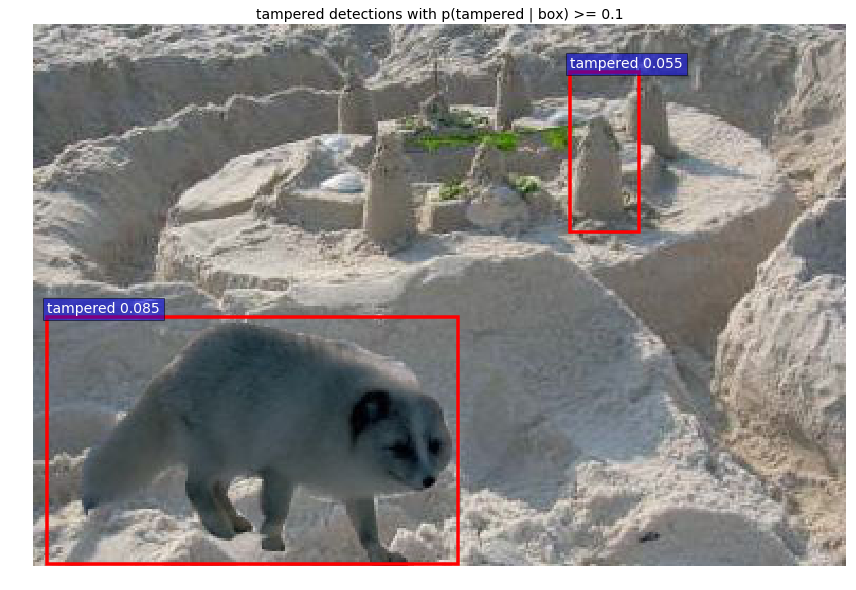

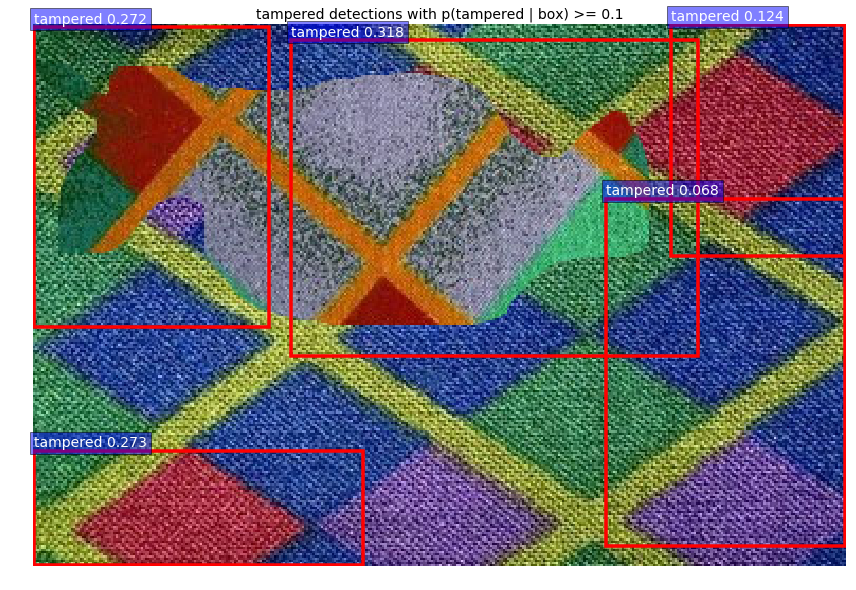

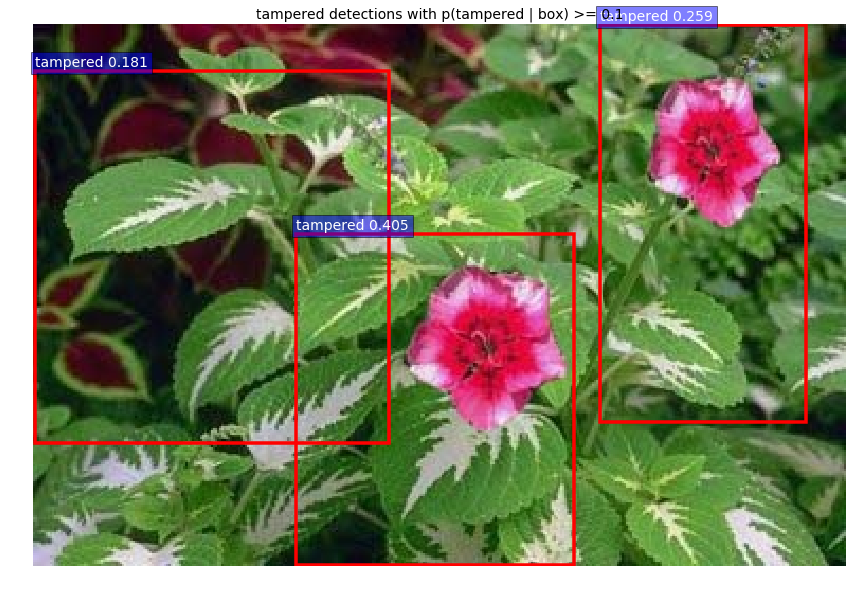

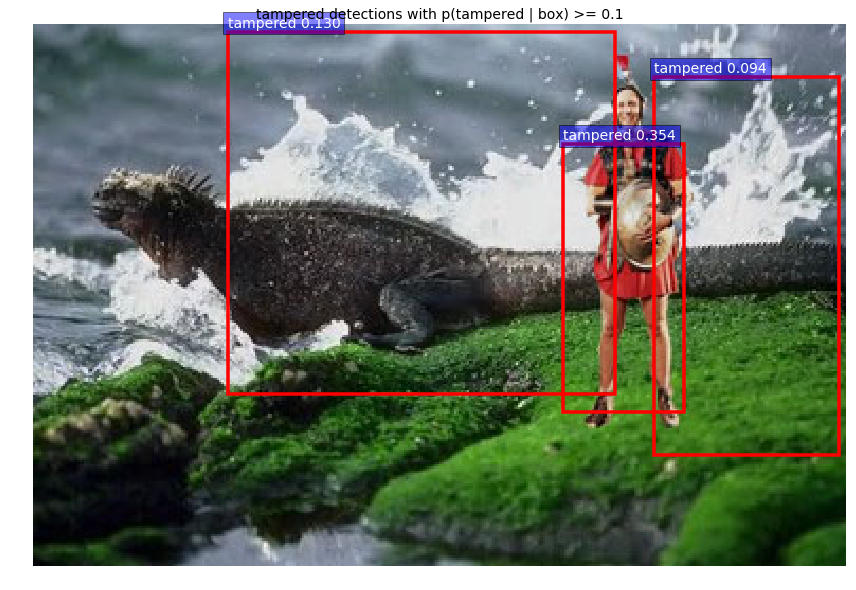

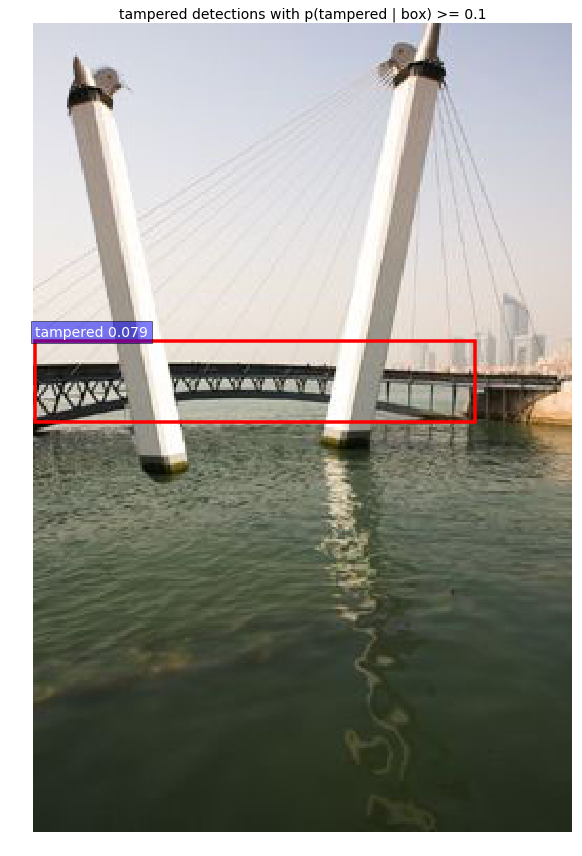

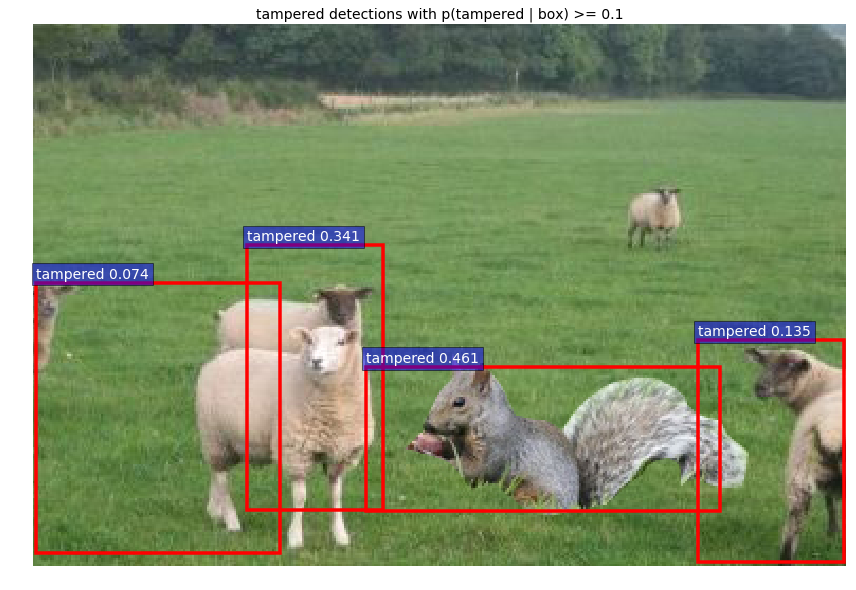

In [5]:
# --------------------------------------------------------
# Tensorflow Faster R-CNN
# Licensed under The MIT License [see LICENSE for details]
# Written by Hangyan Jiang, based on code from Ross Girshick
# --------------------------------------------------------

CLASSES = ('__background__',
           'tampered')

# PLEASE specify weight files dir for vgg16
NETS = {'vgg16': ('vgg16_faster_rcnn_iter_1000.ckpt',), 'res101': ('res101_faster_rcnn_iter_110000.ckpt',)}
DATASETS = {'pascal_voc': ('voc_2007_trainval',), 'pascal_voc_0712': ('voc_2007_trainval+voc_2012_trainval',)}

tf.reset_default_graph()
def vis_detections(im, class_name, dets, thresh=0.5):
    """Draw detected bounding boxes."""
    inds = np.where(dets[:, -1] >= thresh)[0]
    if len(inds) == 0:
        return

    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im, aspect='equal')
    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]

        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5)
        )
        ax.text(bbox[0], bbox[1] - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')

    ax.set_title(('{} detections with '
                  'p({} | box) >= {:.1f}').format(class_name, class_name,
                                                  thresh),
                 fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.draw()


def demo(sess, net, image_name):
    """Detect object classes in an image using pre-computed object proposals."""

    # Load the demo image
    im_file = os.path.join('lib/layer_utils', image_name)
    im = cv2.imread(im_file)

    # Detect all object classes and regress object bounds
    timer = Timer()
    timer.tic()
    scores, boxes = im_detect(sess, net, im)
    timer.toc()
    print('Detection took {:.3f}s for {:d} object proposals'.format(timer.total_time, boxes.shape[0]))

    # Visualize detections for each class
    CONF_THRESH = 0.05
    NMS_THRESH = 0.1

    for cls_ind, cls in enumerate(CLASSES[1:]):
        cls_ind += 1  # because we skipped background
        cls_boxes = boxes[:, 4 * cls_ind:4 * (cls_ind + 1)]
        cls_scores = scores[:, cls_ind]
        dets = np.hstack((cls_boxes,
                          cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(dets, NMS_THRESH)
        dets = dets[keep, :]
        vis_detections(im, cls, dets, thresh=CONF_THRESH)


def parse_args():
    """Parse input arguments."""
    parser = argparse.ArgumentParser(description='Tensorflow Faster R-CNN demo')
    parser.add_argument('--net', dest='demo_net', help='Network to use [vgg16 res101]',
                        choices=NETS.keys(), default='vgg16')
    parser.add_argument('--dataset', dest='dataset', help='Trained dataset [pascal_voc pascal_voc_0712]',
                        choices=DATASETS.keys(), default='pascal_voc_0712')
    args = parser.parse_args(args=[])

    return args


if __name__ == '__main__':
    args = parse_args()

    # model path
    demonet = args.demo_net
    dataset = args.dataset
    tfmodel = os.path.join('default', 'DIY_dataset', 'default', NETS[demonet][0])

    if not os.path.isfile(tfmodel + '.meta'):
        print(tfmodel)
        raise IOError(('{:s} not found.\nDid you download the proper networks from '
                       'our server and place them properly?').format(tfmodel + '.meta'))

    # set config
    tfconfig = tf.ConfigProto(allow_soft_placement=True)
    tfconfig.gpu_options.allow_growth = True

    # init session
    sess = tf.Session(config=tfconfig)
    # load network
    if demonet == 'vgg16':
        net = vgg16(batch_size=1)
    # elif demonet == 'res101':
        # net = resnetv1(batch_size=1, num_layers=101)
    else:
        raise NotImplementedError
    net.create_architecture(sess, "TEST", 2,
                            tag='default', anchor_scales=[8, 16, 32])
    saver = tf.train.Saver()
    saver.restore(sess, tfmodel)

    print('Loaded network {:s}'.format(tfmodel))

    for file in os.listdir("./lib/layer_utils"):
        if file.endswith(".jpg"):
            print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
            print('Demo for lib/layer_utils/{}'.format(file))
            demo(sess, net, file)

    plt.show()

INFO:tensorflow:Restoring parameters from default/DIY_dataset/default/vgg16_faster_rcnn_iter_800.ckpt
Loaded network default/DIY_dataset/default/vgg16_faster_rcnn_iter_800.ckpt
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_CRN_A_sec0083_ani0039_0401.jpg
Detection took 4.350s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_NNN_A_txt0062_txt0060_0149.jpg
Detection took 4.147s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_CRN_A_pla0006_pla0009_0391.jpg
Detection took 4.355s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_NRN_A_ani0056_cha0062_0437.jpg
Detection took 4.008s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_NNN_R_arc0088_arc0088_0367.jpg
Detection took 4.180s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_NRN_A_ani0082_ani0097_0427.jpg
Detect

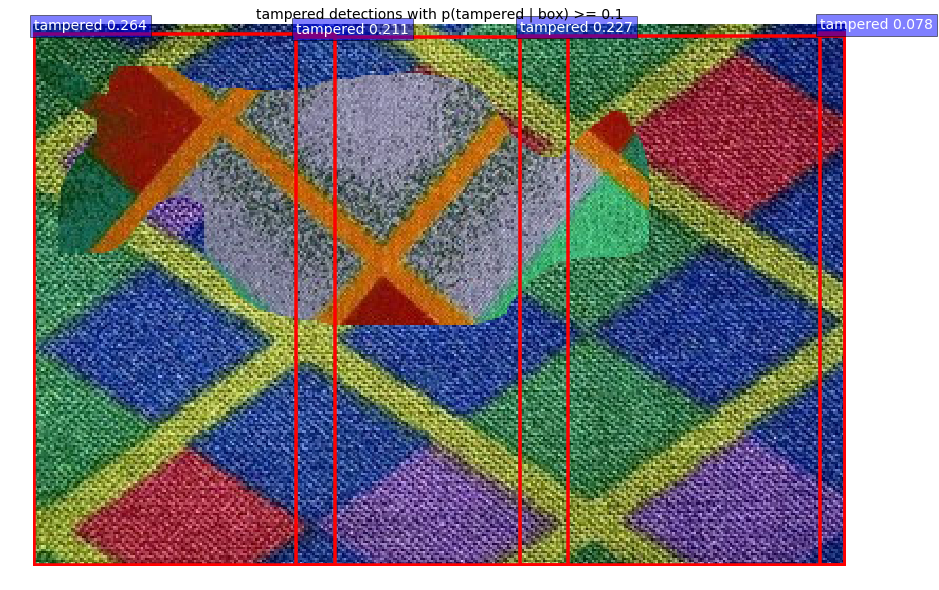

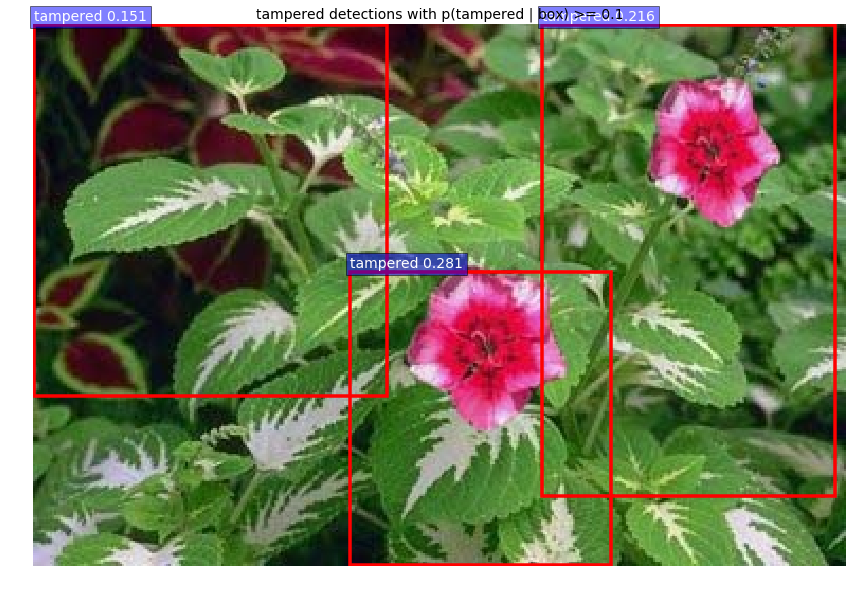

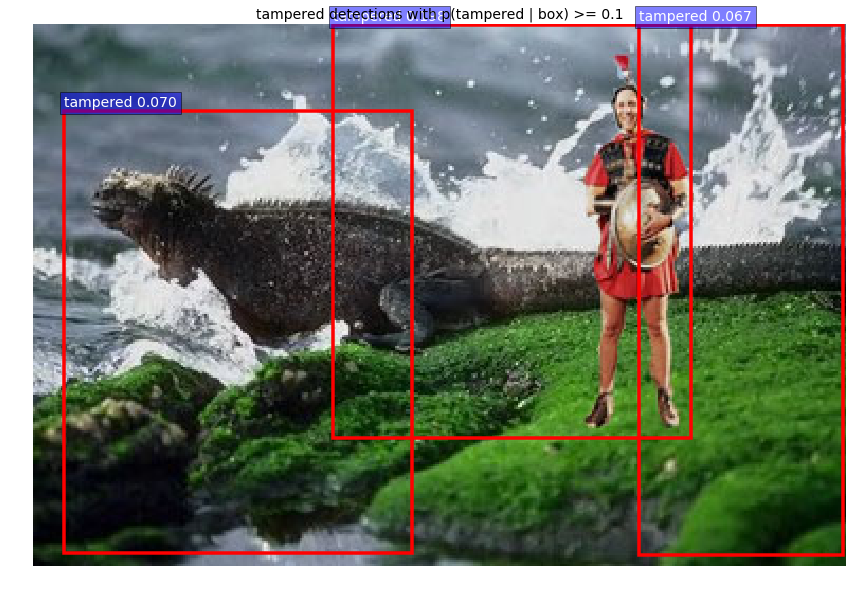

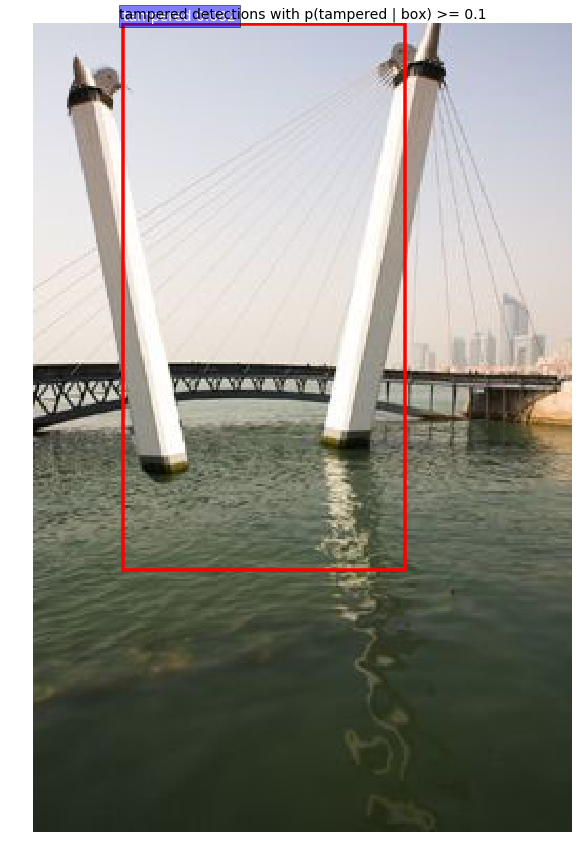

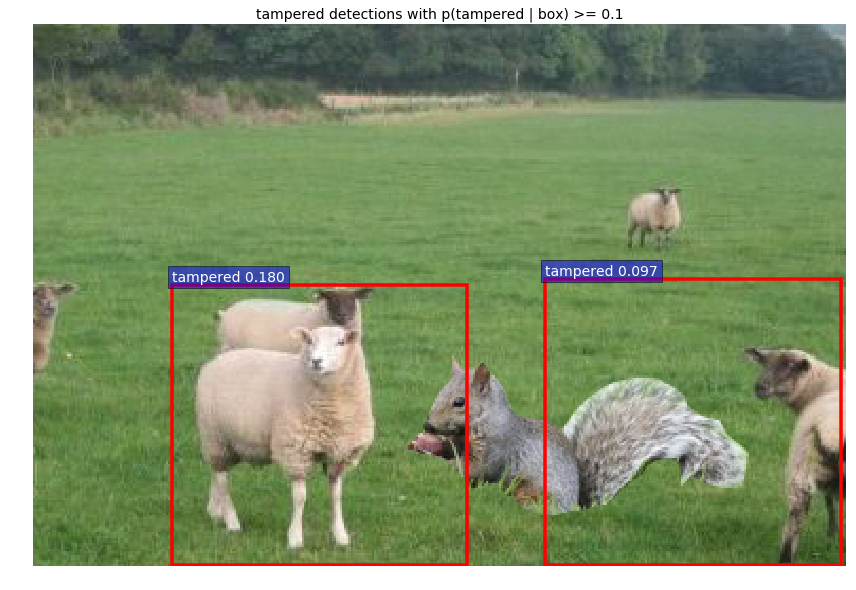

In [6]:
# --------------------------------------------------------
# Tensorflow Faster R-CNN
# Licensed under The MIT License [see LICENSE for details]
# Written by Hangyan Jiang, based on code from Ross Girshick
# --------------------------------------------------------

CLASSES = ('__background__',
           'tampered')

# PLEASE specify weight files dir for vgg16
NETS = {'vgg16': ('vgg16_faster_rcnn_iter_800.ckpt',), 'res101': ('res101_faster_rcnn_iter_110000.ckpt',)}
DATASETS = {'pascal_voc': ('voc_2007_trainval',), 'pascal_voc_0712': ('voc_2007_trainval+voc_2012_trainval',)}

tf.reset_default_graph()
def vis_detections(im, class_name, dets, thresh=0.5):
    """Draw detected bounding boxes."""
    inds = np.where(dets[:, -1] >= thresh)[0]
    if len(inds) == 0:
        return

    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im, aspect='equal')
    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]

        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5)
        )
        ax.text(bbox[0], bbox[1] - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')

    ax.set_title(('{} detections with '
                  'p({} | box) >= {:.1f}').format(class_name, class_name,
                                                  thresh),
                 fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.draw()


def demo(sess, net, image_name):
    """Detect object classes in an image using pre-computed object proposals."""

    # Load the demo image
    im_file = os.path.join('lib/layer_utils', image_name)
    im = cv2.imread(im_file)

    # Detect all object classes and regress object bounds
    timer = Timer()
    timer.tic()
    scores, boxes = im_detect(sess, net, im)
    timer.toc()
    print('Detection took {:.3f}s for {:d} object proposals'.format(timer.total_time, boxes.shape[0]))

    # Visualize detections for each class
    CONF_THRESH = 0.05
    NMS_THRESH = 0.1

    for cls_ind, cls in enumerate(CLASSES[1:]):
        cls_ind += 1  # because we skipped background
        cls_boxes = boxes[:, 4 * cls_ind:4 * (cls_ind + 1)]
        cls_scores = scores[:, cls_ind]
        dets = np.hstack((cls_boxes,
                          cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(dets, NMS_THRESH)
        dets = dets[keep, :]
        vis_detections(im, cls, dets, thresh=CONF_THRESH)


def parse_args():
    """Parse input arguments."""
    parser = argparse.ArgumentParser(description='Tensorflow Faster R-CNN demo')
    parser.add_argument('--net', dest='demo_net', help='Network to use [vgg16 res101]',
                        choices=NETS.keys(), default='vgg16')
    parser.add_argument('--dataset', dest='dataset', help='Trained dataset [pascal_voc pascal_voc_0712]',
                        choices=DATASETS.keys(), default='pascal_voc_0712')
    args = parser.parse_args(args=[])

    return args


if __name__ == '__main__':
    args = parse_args()

    # model path
    demonet = args.demo_net
    dataset = args.dataset
    tfmodel = os.path.join('default', 'DIY_dataset', 'default', NETS[demonet][0])

    if not os.path.isfile(tfmodel + '.meta'):
        print(tfmodel)
        raise IOError(('{:s} not found.\nDid you download the proper networks from '
                       'our server and place them properly?').format(tfmodel + '.meta'))

    # set config
    tfconfig = tf.ConfigProto(allow_soft_placement=True)
    tfconfig.gpu_options.allow_growth = True

    # init session
    sess = tf.Session(config=tfconfig)
    # load network
    if demonet == 'vgg16':
        net = vgg16(batch_size=1)
    # elif demonet == 'res101':
        # net = resnetv1(batch_size=1, num_layers=101)
    else:
        raise NotImplementedError
    net.create_architecture(sess, "TEST", 2,
                            tag='default', anchor_scales=[8, 16, 32])
    saver = tf.train.Saver()
    saver.restore(sess, tfmodel)

    print('Loaded network {:s}'.format(tfmodel))

    for file in os.listdir("./lib/layer_utils"):
        if file.endswith(".jpg"):
            print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
            print('Demo for lib/layer_utils/{}'.format(file))
            demo(sess, net, file)

    plt.show()

INFO:tensorflow:Restoring parameters from default/DIY_dataset/default/vgg16_faster_rcnn_iter_40000.ckpt
Loaded network default/DIY_dataset/default/vgg16_faster_rcnn_iter_40000.ckpt
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_CRN_A_sec0083_ani0039_0401.jpg
Detection took 4.431s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_NNN_A_txt0062_txt0060_0149.jpg
Detection took 4.137s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_CRN_A_pla0006_pla0009_0391.jpg
Detection took 4.157s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_NRN_A_ani0056_cha0062_0437.jpg
Detection took 4.115s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_NNN_R_arc0088_arc0088_0367.jpg
Detection took 4.199s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_NRN_A_ani0082_ani0097_0427.jpg
De

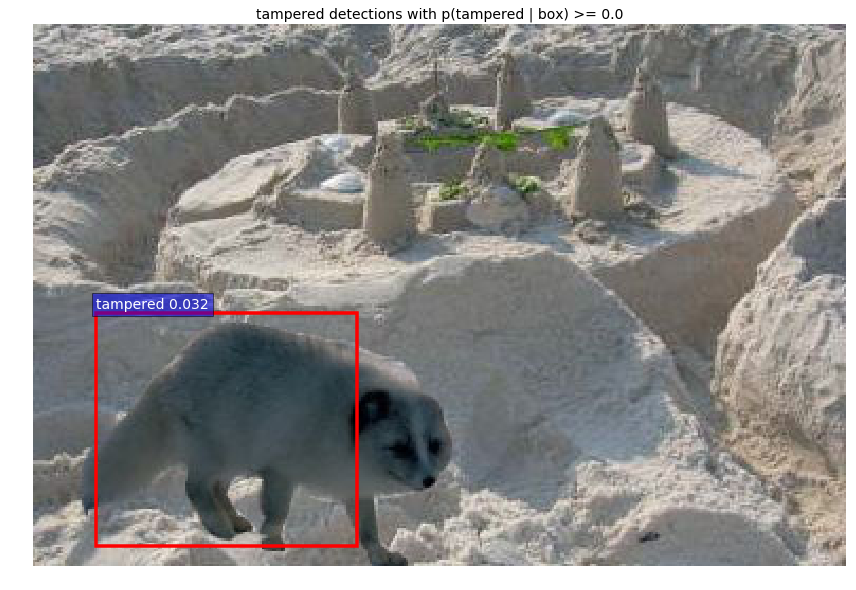

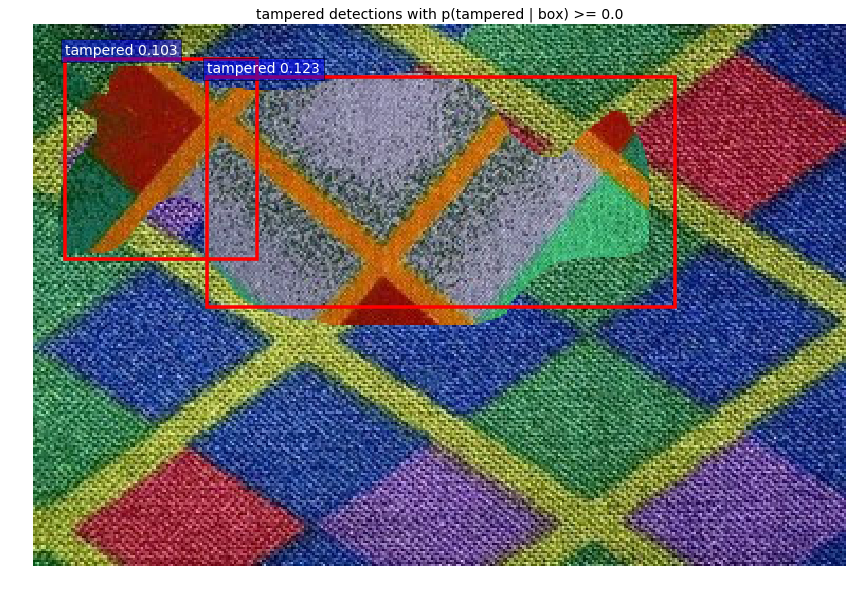

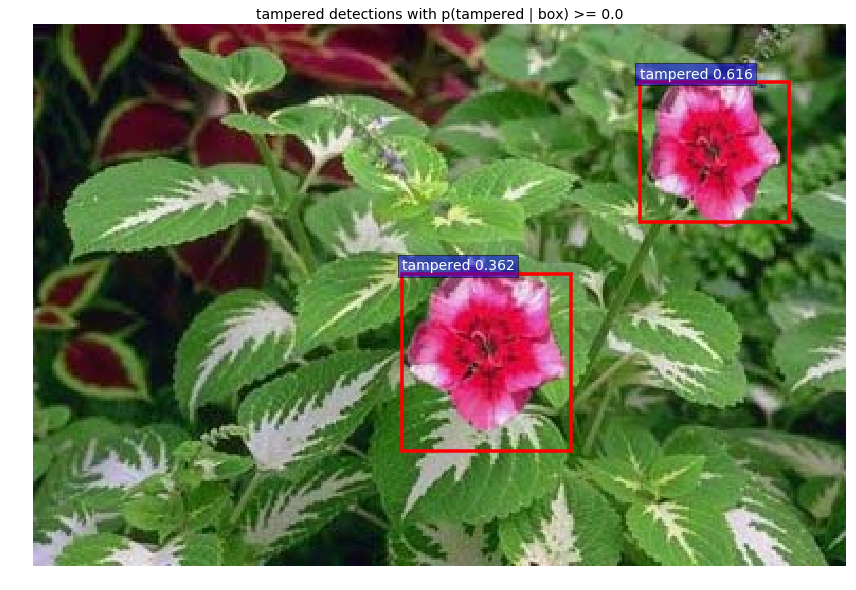

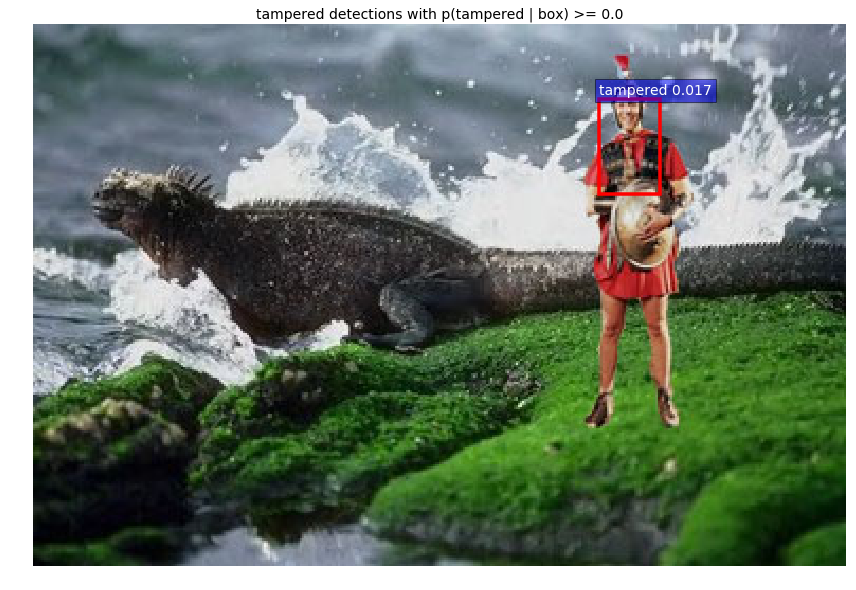

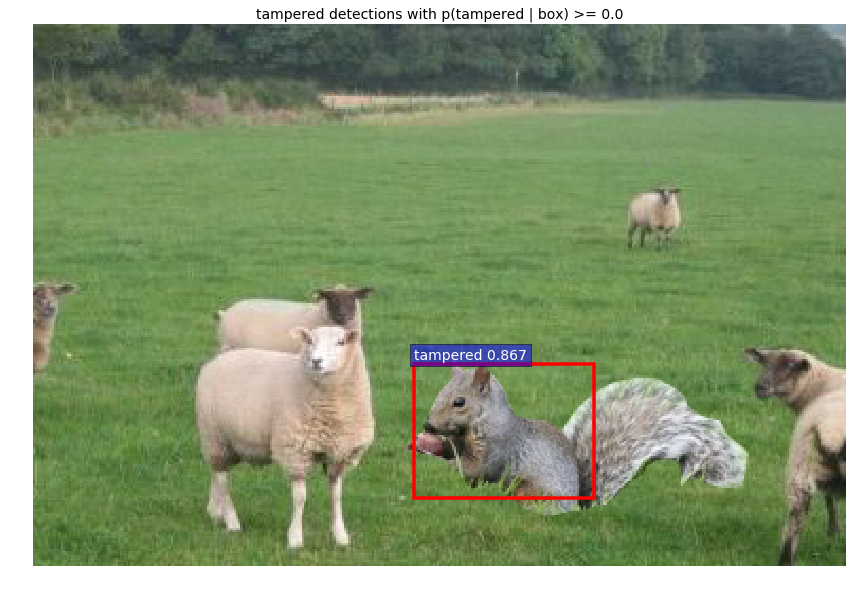

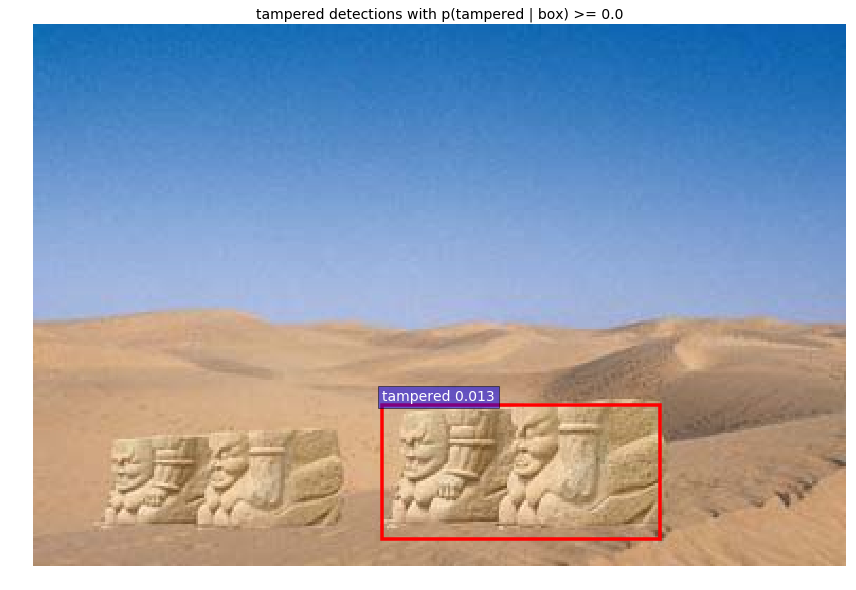

In [9]:
# --------------------------------------------------------
# Tensorflow Faster R-CNN
# Licensed under The MIT License [see LICENSE for details]
# Written by Hangyan Jiang, based on code from Ross Girshick
# --------------------------------------------------------

CLASSES = ('__background__',
           'tampered')

# PLEASE specify weight files dir for vgg16
NETS = {'vgg16': ('vgg16_faster_rcnn_iter_40000.ckpt',), 'res101': ('res101_faster_rcnn_iter_110000.ckpt',)}
DATASETS = {'pascal_voc': ('voc_2007_trainval',), 'pascal_voc_0712': ('voc_2007_trainval+voc_2012_trainval',)}

tf.reset_default_graph()
def vis_detections(im, class_name, dets, thresh=0.5):
    """Draw detected bounding boxes."""
    inds = np.where(dets[:, -1] >= thresh)[0]
    if len(inds) == 0:
        return

    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im, aspect='equal')
    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]

        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5)
        )
        ax.text(bbox[0], bbox[1] - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')

    ax.set_title(('{} detections with '
                  'p({} | box) >= {:.1f}').format(class_name, class_name,
                                                  thresh),
                 fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.draw()


def demo(sess, net, image_name):
    """Detect object classes in an image using pre-computed object proposals."""

    # Load the demo image
    im_file = os.path.join('lib/layer_utils', image_name)
    im = cv2.imread(im_file)

    # Detect all object classes and regress object bounds
    timer = Timer()
    timer.tic()
    scores, boxes = im_detect(sess, net, im)
    timer.toc()
    print('Detection took {:.3f}s for {:d} object proposals'.format(timer.total_time, boxes.shape[0]))

    # Visualize detections for each class
    CONF_THRESH = 0.01
    NMS_THRESH = 0.1

    for cls_ind, cls in enumerate(CLASSES[1:]):
        cls_ind += 1  # because we skipped background
        cls_boxes = boxes[:, 4 * cls_ind:4 * (cls_ind + 1)]
        cls_scores = scores[:, cls_ind]
        dets = np.hstack((cls_boxes,
                          cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(dets, NMS_THRESH)
        dets = dets[keep, :]
        vis_detections(im, cls, dets, thresh=CONF_THRESH)


def parse_args():
    """Parse input arguments."""
    parser = argparse.ArgumentParser(description='Tensorflow Faster R-CNN demo')
    parser.add_argument('--net', dest='demo_net', help='Network to use [vgg16 res101]',
                        choices=NETS.keys(), default='vgg16')
    parser.add_argument('--dataset', dest='dataset', help='Trained dataset [pascal_voc pascal_voc_0712]',
                        choices=DATASETS.keys(), default='pascal_voc_0712')
    args = parser.parse_args(args=[])

    return args


if __name__ == '__main__':
    args = parse_args()

    # model path
    demonet = args.demo_net
    dataset = args.dataset
    tfmodel = os.path.join('default', 'DIY_dataset', 'default', NETS[demonet][0])

    if not os.path.isfile(tfmodel + '.meta'):
        print(tfmodel)
        raise IOError(('{:s} not found.\nDid you download the proper networks from '
                       'our server and place them properly?').format(tfmodel + '.meta'))

    # set config
    tfconfig = tf.ConfigProto(allow_soft_placement=True)
    tfconfig.gpu_options.allow_growth = True

    # init session
    sess = tf.Session(config=tfconfig)
    # load network
    if demonet == 'vgg16':
        net = vgg16(batch_size=1)
    # elif demonet == 'res101':
        # net = resnetv1(batch_size=1, num_layers=101)
    else:
        raise NotImplementedError
    net.create_architecture(sess, "TEST", 2,
                            tag='default', anchor_scales=[8, 16, 32])
    saver = tf.train.Saver()
    saver.restore(sess, tfmodel)

    print('Loaded network {:s}'.format(tfmodel))

    for file in os.listdir("./lib/layer_utils"):
        if file.endswith(".jpg"):
            print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
            print('Demo for lib/layer_utils/{}'.format(file))
            demo(sess, net, file)

    plt.show()

INFO:tensorflow:Restoring parameters from default/DIY_dataset/default/vgg16_faster_rcnn_iter_400.ckpt
Loaded network default/DIY_dataset/default/vgg16_faster_rcnn_iter_400.ckpt
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_CRN_A_sec0083_ani0039_0401.jpg
Detection took 4.337s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_NNN_A_txt0062_txt0060_0149.jpg
Detection took 4.214s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_CRN_A_pla0006_pla0009_0391.jpg
Detection took 4.076s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_NRN_A_ani0056_cha0062_0437.jpg
Detection took 4.408s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_NNN_R_arc0088_arc0088_0367.jpg
Detection took 4.128s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_NRN_A_ani0082_ani0097_0427.jpg
Detect

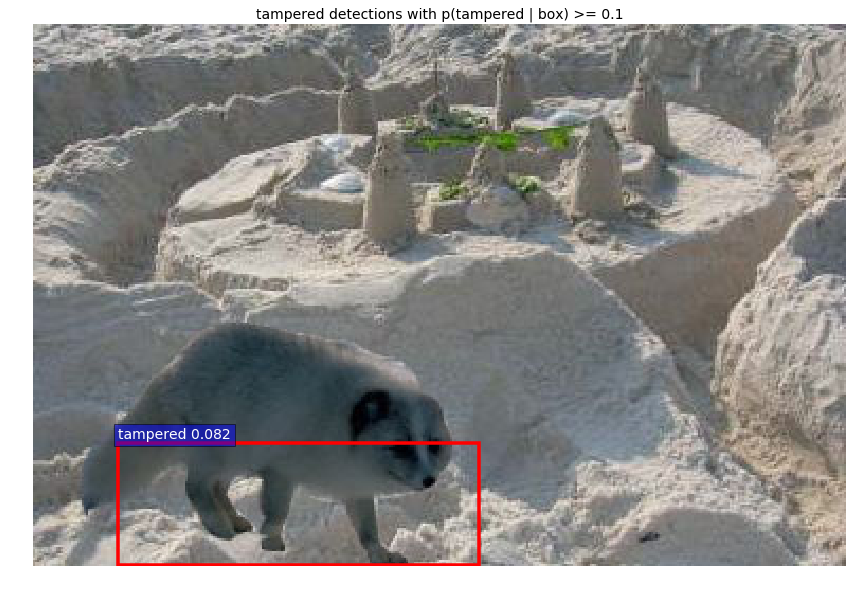

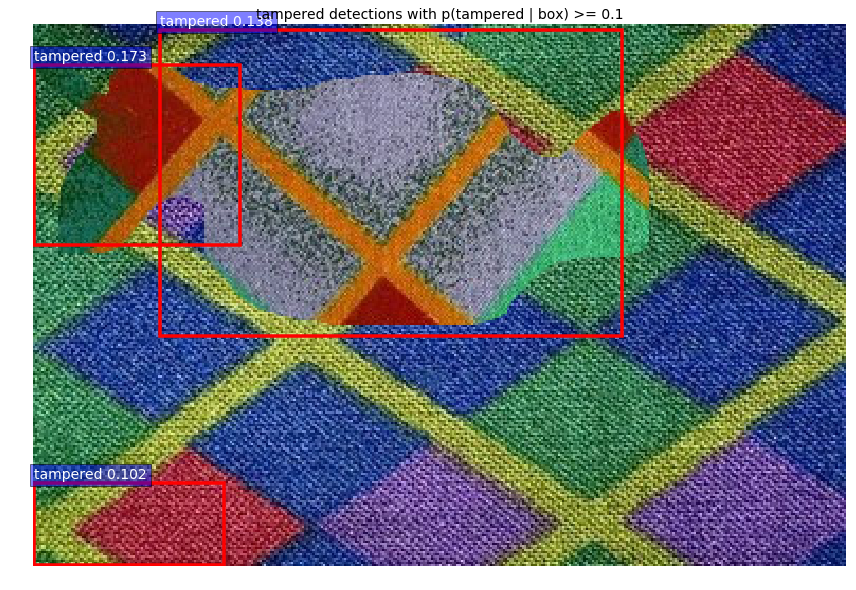

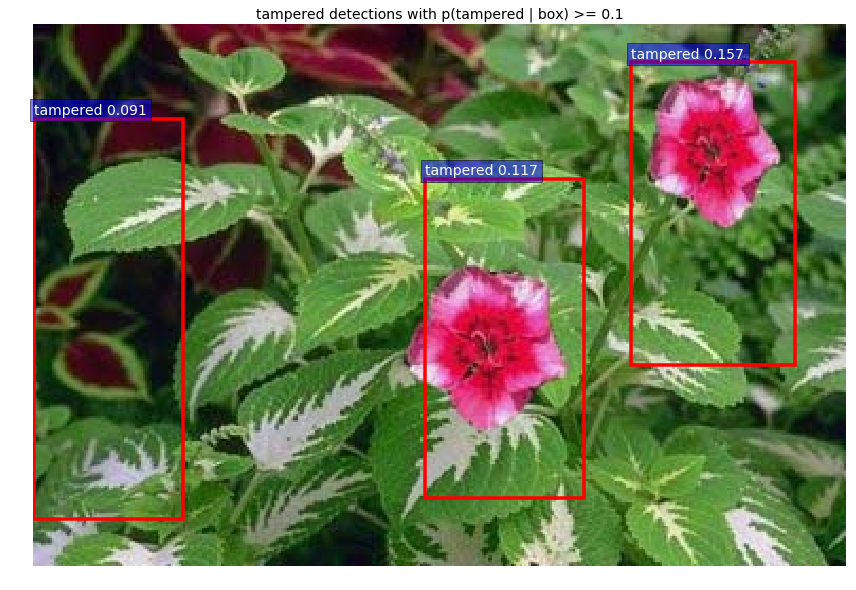

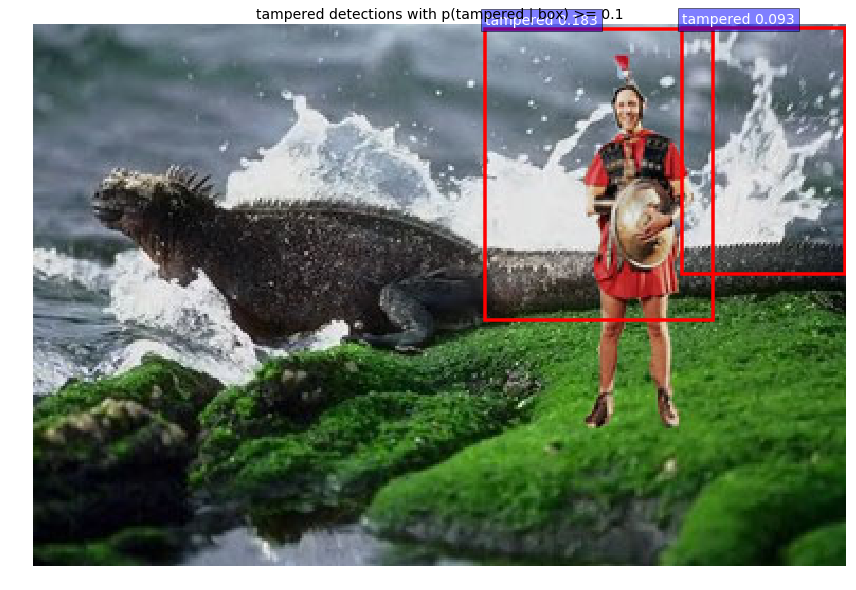

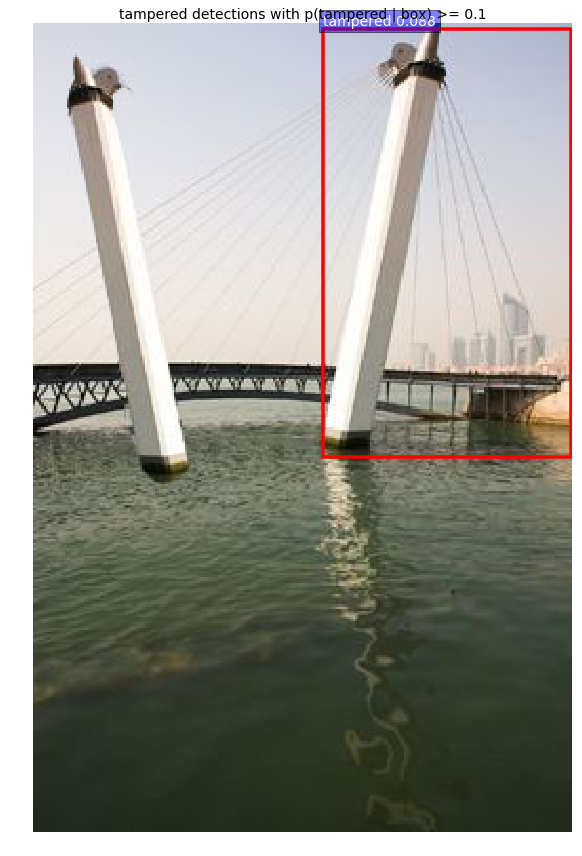

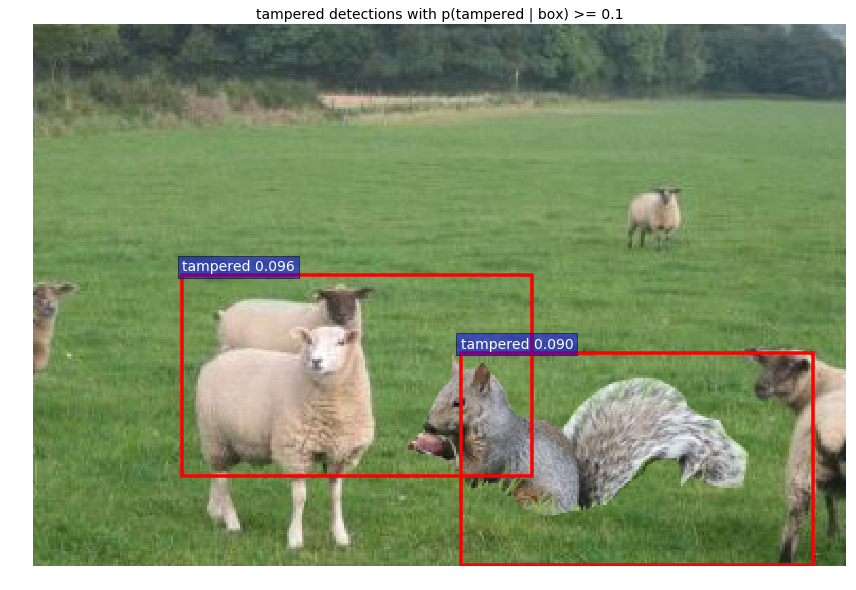

In [11]:
# --------------------------------------------------------
# Tensorflow Faster R-CNN
# Licensed under The MIT License [see LICENSE for details]
# Written by Hangyan Jiang, based on code from Ross Girshick
# --------------------------------------------------------

CLASSES = ('__background__',
           'tampered')

# PLEASE specify weight files dir for vgg16
NETS = {'vgg16': ('vgg16_faster_rcnn_iter_400.ckpt',), 'res101': ('res101_faster_rcnn_iter_110000.ckpt',)}
DATASETS = {'pascal_voc': ('voc_2007_trainval',), 'pascal_voc_0712': ('voc_2007_trainval+voc_2012_trainval',)}

tf.reset_default_graph()
def vis_detections(im, class_name, dets, thresh=0.5):
    """Draw detected bounding boxes."""
    inds = np.where(dets[:, -1] >= thresh)[0]
    if len(inds) == 0:
        return

    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im, aspect='equal')
    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]

        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5)
        )
        ax.text(bbox[0], bbox[1] - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')

    ax.set_title(('{} detections with '
                  'p({} | box) >= {:.1f}').format(class_name, class_name,
                                                  thresh),
                 fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.draw()


def demo(sess, net, image_name):
    """Detect object classes in an image using pre-computed object proposals."""

    # Load the demo image
    im_file = os.path.join('lib/layer_utils', image_name)
    im = cv2.imread(im_file)

    # Detect all object classes and regress object bounds
    timer = Timer()
    timer.tic()
    scores, boxes = im_detect(sess, net, im)
    timer.toc()
    print('Detection took {:.3f}s for {:d} object proposals'.format(timer.total_time, boxes.shape[0]))

    # Visualize detections for each class
    CONF_THRESH = 0.08
    NMS_THRESH = 0.1

    for cls_ind, cls in enumerate(CLASSES[1:]):
        cls_ind += 1  # because we skipped background
        cls_boxes = boxes[:, 4 * cls_ind:4 * (cls_ind + 1)]
        cls_scores = scores[:, cls_ind]
        dets = np.hstack((cls_boxes,
                          cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(dets, NMS_THRESH)
        dets = dets[keep, :]
        vis_detections(im, cls, dets, thresh=CONF_THRESH)


def parse_args():
    """Parse input arguments."""
    parser = argparse.ArgumentParser(description='Tensorflow Faster R-CNN demo')
    parser.add_argument('--net', dest='demo_net', help='Network to use [vgg16 res101]',
                        choices=NETS.keys(), default='vgg16')
    parser.add_argument('--dataset', dest='dataset', help='Trained dataset [pascal_voc pascal_voc_0712]',
                        choices=DATASETS.keys(), default='pascal_voc_0712')
    args = parser.parse_args(args=[])

    return args


if __name__ == '__main__':
    args = parse_args()

    # model path
    demonet = args.demo_net
    dataset = args.dataset
    tfmodel = os.path.join('default', 'DIY_dataset', 'default', NETS[demonet][0])

    if not os.path.isfile(tfmodel + '.meta'):
        print(tfmodel)
        raise IOError(('{:s} not found.\nDid you download the proper networks from '
                       'our server and place them properly?').format(tfmodel + '.meta'))

    # set config
    tfconfig = tf.ConfigProto(allow_soft_placement=True)
    tfconfig.gpu_options.allow_growth = True

    # init session
    sess = tf.Session(config=tfconfig)
    # load network
    if demonet == 'vgg16':
        net = vgg16(batch_size=1)
    # elif demonet == 'res101':
        # net = resnetv1(batch_size=1, num_layers=101)
    else:
        raise NotImplementedError
    net.create_architecture(sess, "TEST", 2,
                            tag='default', anchor_scales=[8, 16, 32])
    saver = tf.train.Saver()
    saver.restore(sess, tfmodel)

    print('Loaded network {:s}'.format(tfmodel))

    for file in os.listdir("./lib/layer_utils"):
        if file.endswith(".jpg"):
            print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
            print('Demo for lib/layer_utils/{}'.format(file))
            demo(sess, net, file)

    plt.show()